# Analiza średnich temperatur dziennych w Warszawie i Lizbonie

## Linki
- overleaf - https://www.overleaf.com/project/66298573c5690e43b5b33c70

## Biblioteki

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

colors = ['#cd203b', '#006300']

## Przygotowanie danych

Odczyt danych w których pozostawiliśmy tylko Warszawę i Lisbonę (edycja w Excel)

In [3]:
data_path_warsaw_lisbon = 'warsawlisbon.csv'
warsaw_lisbon_data = pd.read_csv(data_path_warsaw_lisbon)

warsaw_lisbon_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Poland,NaN,Warsaw,1,1,1995,35.4
1,Europe,Poland,NaN,Warsaw,1,2,1995,30.5
2,Europe,Poland,NaN,Warsaw,1,3,1995,27.2
3,Europe,Poland,NaN,Warsaw,1,4,1995,22.9
4,Europe,Poland,NaN,Warsaw,1,5,1995,18.7


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [4]:
warsaw_lisbon_data = warsaw_lisbon_data.drop('Region', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('Country', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('State', axis=1)

warsaw_lisbon_data

,City,Month,Day,Year,AvgTemperature
0,Warsaw,1,1,1995,35.4
1,Warsaw,1,2,1995,30.5
2,Warsaw,1,3,1995,27.2
3,Warsaw,1,4,1995,22.9
4,Warsaw,1,5,1995,18.7
...,...,...,...,...,...
18527,Lisbon,5,9,2020,59.8
18528,Lisbon,5,10,2020,60.0
18529,Lisbon,5,11,2020,60.3
18530,Lisbon,5,12,2020,59.6


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [5]:
warsaw_lisbon_data["Month"] = pd.to_numeric(warsaw_lisbon_data["Month"])
warsaw_lisbon_data["Day"] = pd.to_numeric(warsaw_lisbon_data["Day"])
warsaw_lisbon_data["Year"] = pd.to_numeric(warsaw_lisbon_data["Year"])
warsaw_lisbon_data["AvgTemperature"] = pd.to_numeric(warsaw_lisbon_data["AvgTemperature"])

Dzielimy dane na miasta i sortujemy datą

In [6]:
warsaw_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Warsaw']
lisbon_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Lisbon']

warsaw_data['Date'] = pd.to_datetime(warsaw_data[['Year', 'Month', 'Day']])
lisbon_data['Date'] = pd.to_datetime(lisbon_data[['Year', 'Month', 'Day']])

warsaw_data = warsaw_data.sort_values(by='Date')
lisbon_data = lisbon_data.sort_values(by='Date')

### Błędna numeracja wierszy

Natomiast po takim podziale, zauważmy że występuje problem z numeracją wierszy

In [7]:
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
9266,Lisbon,1,1,1995,53.5,1995-01-01
9267,Lisbon,1,2,1995,46.9,1995-01-02
9268,Lisbon,1,3,1995,45.8,1995-01-03
9269,Lisbon,1,4,1995,53.3,1995-01-04
9270,Lisbon,1,5,1995,56.2,1995-01-05


Poprawmy go

In [8]:
lisbon_data.reset_index(drop=True, inplace=True)
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
0,Lisbon,1,1,1995,53.5,1995-01-01
1,Lisbon,1,2,1995,46.9,1995-01-02
2,Lisbon,1,3,1995,45.8,1995-01-03
3,Lisbon,1,4,1995,53.3,1995-01-04
4,Lisbon,1,5,1995,56.2,1995-01-05


Zobaczmy jak dane się prezentują na wykresie

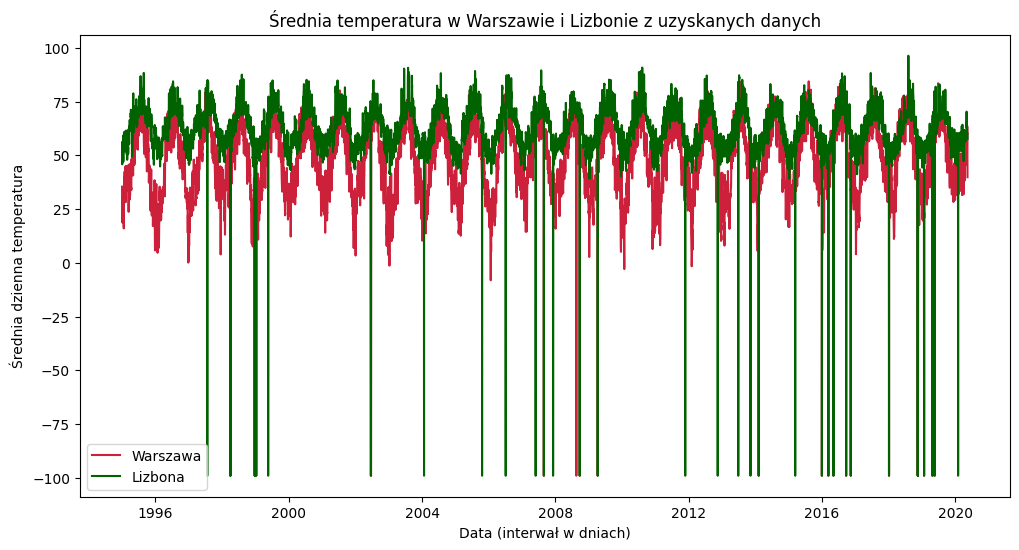

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie z uzyskanych danych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.legend()
plt.show()

### Brakujące wartości

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [10]:
lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
934,Lisbon,7,23,1997,-99.0,1997-07-23
1184,Lisbon,3,30,1998,-99.0,1998-03-30
1189,Lisbon,4,4,1998,-99.0,1998-04-04
1190,Lisbon,4,5,1998,-99.0,1998-04-05
1453,Lisbon,12,24,1998,-99.0,1998-12-24


Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [11]:
lisbon_data['AvgTemperature_New'] = lisbon_data['AvgTemperature']

for i in range(len(lisbon_data)):
    if lisbon_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = lisbon_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        lisbon_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature_New']
lisbon_data = lisbon_data.drop('AvgTemperature_New', axis=1)

lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. To samo robimy dla Warszawy.

In [12]:
warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
1453,Warsaw,12,24,1998,-99.0,1998-12-24
1454,Warsaw,12,25,1998,-99.0,1998-12-25
1459,Warsaw,12,30,1998,-99.0,1998-12-30
1460,Warsaw,12,31,1998,-99.0,1998-12-31
1470,Warsaw,1,10,1999,-99.0,1999-01-10


In [13]:
warsaw_data['AvgTemperature_New'] = warsaw_data['AvgTemperature']

for i in range(len(warsaw_data)):
    if warsaw_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = warsaw_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        warsaw_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature_New']
warsaw_data = warsaw_data.drop('AvgTemperature_New', axis=1)

warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Zobaczmy wykres po tych modyfikacjach

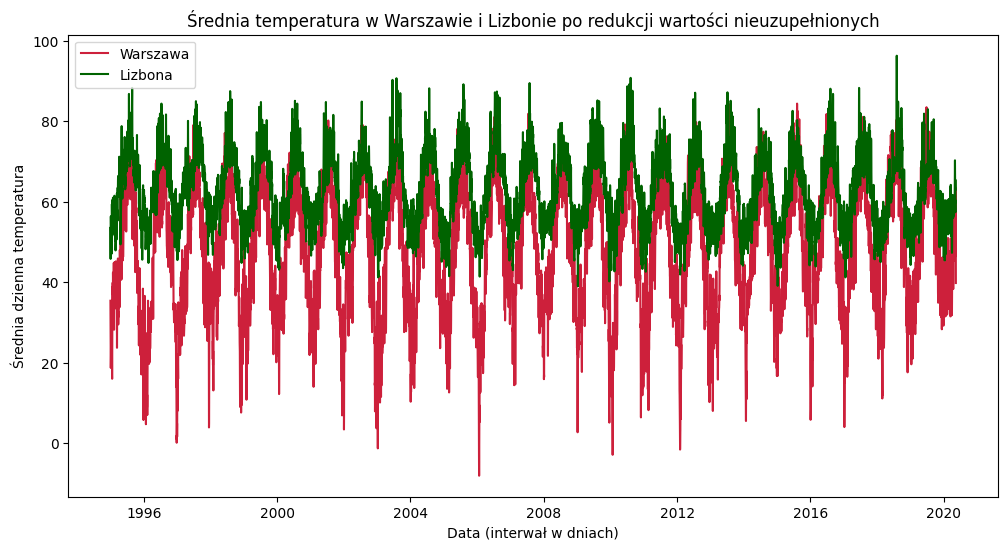

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie po redukcji wartości nieuzupełnionych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.legend()
plt.show()

### Konwersja stopni

Wartośc są mniej niepokojące jednak 100 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [15]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature'].apply(fahrenheit_to_celsius)
lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

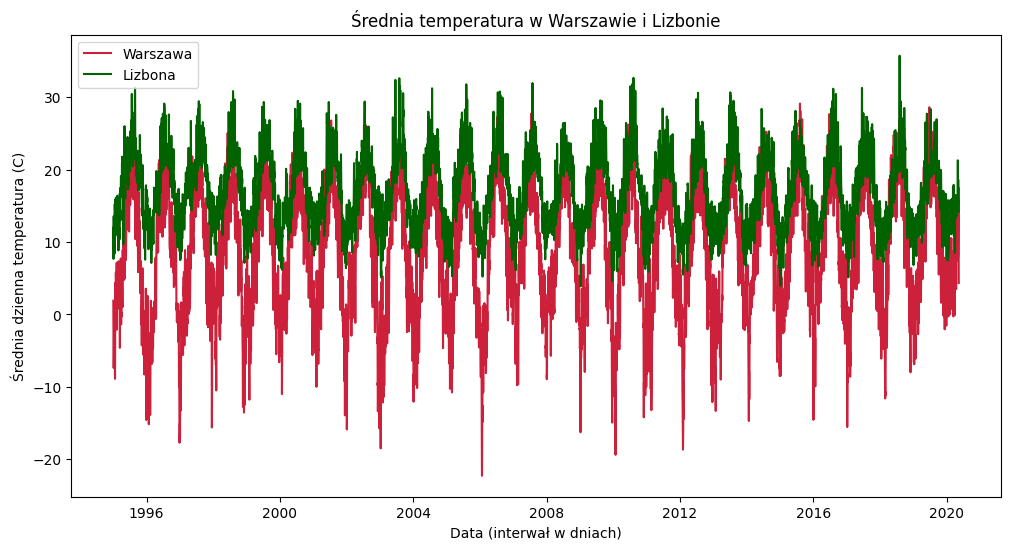

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura (C)')

plt.legend()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

Rozpocznijmy od zastosowania podstawowych pojęć statystycznych do tych danych

- Warszawa

In [17]:
warsaw_data['AvgTemperature'].describe()

count    9266.000000
mean        9.026345
std         8.719466
min       -22.277778
25%         2.277778
50%         9.222222
75%        16.222222
max        29.111111
Name: AvgTemperature, dtype: float64

- Lizbona

In [18]:
lisbon_data['AvgTemperature'].describe()

count    9266.000000
mean       17.011166
std         4.883680
min         3.888889
25%        13.111111
50%        16.777778
75%        20.722222
max        35.722222
Name: AvgTemperature, dtype: float64

## Analiza danych

### Boxplot

Zacznijmy od poznania danych boxplotem

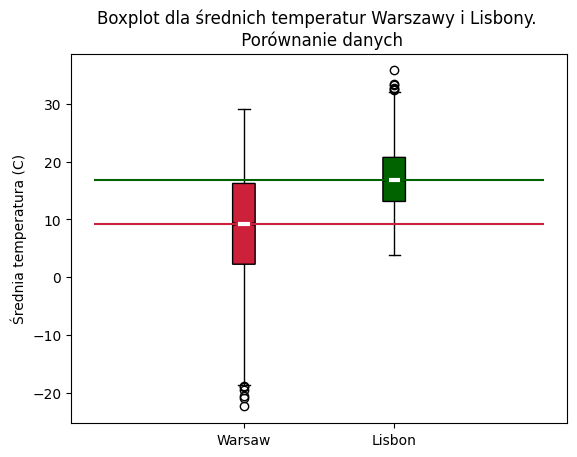

In [19]:
bp = plt.boxplot([warsaw_data.AvgTemperature, lisbon_data.AvgTemperature], patch_artist = True, notch ='True')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# medians
for median in bp['medians']:
    median.set(color ='white',
               linewidth = 3)
            
plt.hlines(warsaw_data.AvgTemperature.median(), 0, 3, color=colors[0])
plt.hlines(lisbon_data.AvgTemperature.median(), 0, 3, color=colors[1])

plt.xticks([1, 2], ['Warsaw', 'Lisbon'])

plt.title('Boxplot dla średnich temperatur Warszawy i Lisbony. \n Porównanie danych')
plt.ylabel('Średnia temperatura (C)')

plt.show()

Tutaj zauważamy już dość sporo informacji o naszych danych:
- Średnia temperatury w Lizbonie jest znacząco wyższa niż w Warszawie. To sugeruje, że Lizbona ma cieplejszy klimat niż Warszawa.
- Zmienność temperatury w Warszawie jest znacznie większa niż w Lizbonie: Odchylenie standardowe dla Warszawy wynosi 8.72°C, podczas gdy dla Lizbony jest to 4.88°C.
- Średnia temperatura Lizbony przekracza trzeci kwartyl Warszawy. To sugeruje, że temperatura w Lizbonie jest ogólnie wyższa niż w Warszawie.

### Gęstość

Następnie spójrzmy na te dane jeszcze na histogramie

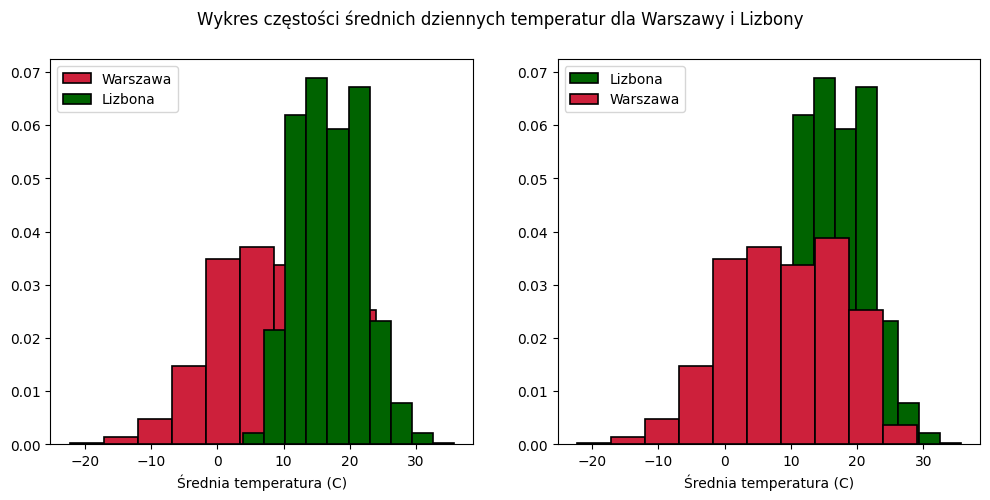

In [20]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5),)

axis[0].hist(warsaw_data.AvgTemperature, density=True, color=colors[0], label='Warszawa', edgecolor='black', linewidth=1.2)
axis[0].hist(lisbon_data.AvgTemperature, density=True, color=colors[1], label='Lizbona', edgecolor='black', linewidth=1.2)

axis[1].hist(lisbon_data.AvgTemperature, density=True, color=colors[1], label='Lizbona', edgecolor='black', linewidth=1.2)
axis[1].hist(warsaw_data.AvgTemperature, density=True, color=colors[0], label='Warszawa', edgecolor='black', linewidth=1.2)

axis[0].legend()
axis[1].legend()

axis[0].set_xlabel('Średnia temperatura (C)')
axis[1].set_xlabel('Średnia temperatura (C)')

figure.suptitle('Wykres częstości średnich dziennych temperatur dla Warszawy i Lizbony')
plt.show()

### Dystrybuanta

Po otrzymaniu histogramu, czyli "empirycznej gęstości" spójrzmy na dystrybuantę

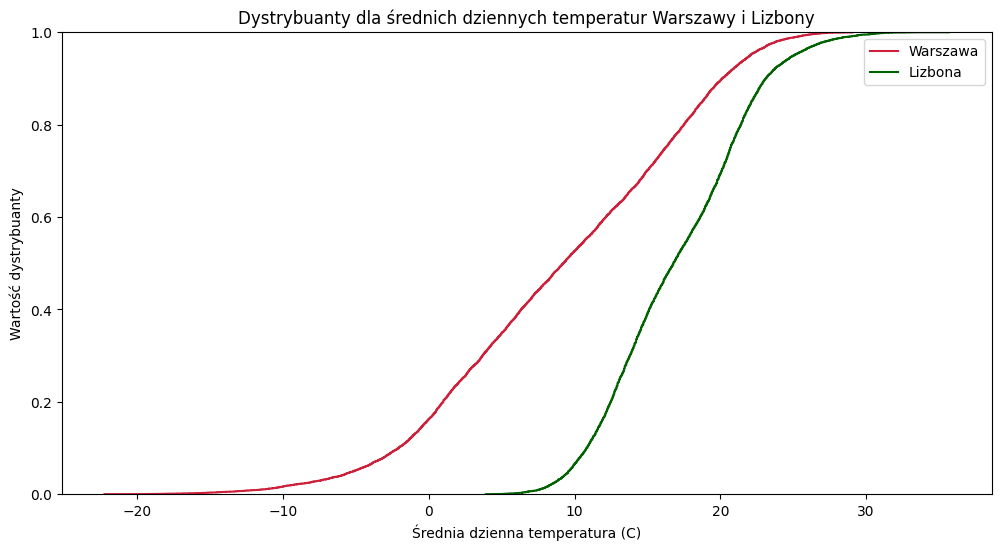

In [21]:
plt.figure(figsize=(12, 6))

sns.ecdfplot(data=warsaw_data.AvgTemperature, label="Warszawa", c=colors[0])
sns.ecdfplot(data=lisbon_data.AvgTemperature, label="Lizbona", c=colors[1])

plt.title('Dystrybuanty dla średnich dziennych temperatur Warszawy i Lizbony')
plt.xlabel('Średnia dzienna temperatura (C)')
plt.ylabel('Wartość dystrybuanty')

plt.legend()
plt.show()

### Średnie

Podczas zajęć poznaliśmy sporo różnych metod obliczania średnich, użyjmy ich do naszych danych

#### Średnia arytmetyczna

In [25]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Średnia arytmetyczna z danych": [
        np.mean(warsaw_data.AvgTemperature),
        np.mean(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Średnia arytmetyczna z danych
0,Warszawa,9.026345
1,Lizbona,17.011166


#### Średnia geometryczna

In [28]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Średnia geometryczna z danych": [
        scipy.stats.gmean(warsaw_data.AvgTemperature),
        scipy.stats.gmean(lisbon_data.AvgTemperature),
    ]
})

df

/home/d3vmotiv/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:267: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


,Miasto,Średnia geometryczna z danych
0,Warszawa,NaN
1,Lizbona,16.278005


#### Średnia harmoniczna

In [29]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Średnia geometryczna z danych": [
        scipy.stats.hmean(warsaw_data.AvgTemperature),
        scipy.stats.gmean(lisbon_data.AvgTemperature),
    ]
})

df

ValueError: Harmonic mean only defined if all elements greater than or equal to zero

#### Średnia ucinana

#### Średnia winsorowska

### Inne wyznaczniki matematyczne

#### Korelacja

In [32]:
def pearson_correlation(X,Y):
    """
    https://www.geeksforgeeks.org/exploring-correlation-in-python/
    """
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

corr = pearson_correlation(warsaw_data.AvgTemperature, lisbon_data.AvgTemperature)

f"Korelacja między danymi Warszawy i Lizbony: {corr}"

'Korelacja między danymi Warszawy i Lizbony: 0.7192633730393783'

#### Wariancja

In [38]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Wariancja z danych": [
        np.var(warsaw_data.AvgTemperature, ddof=1),
        np.var(lisbon_data.AvgTemperature, ddof=1),
    ]
})

df

,Miasto,Wariancja z danych
0,Warszawa,76.029081
1,Lizbona,23.850331


#### Skośność

In [39]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Skośność danych": [
        scipy.stats.skew(warsaw_data.AvgTemperature),
        scipy.stats.skew(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Skośność danych
0,Warszawa,-0.229187
1,Lizbona,0.204054


#### Kurtoza

In [37]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Kurtoza danych": [
        scipy.stats.kurtosis(warsaw_data.AvgTemperature),
        scipy.stats.kurtosis(lisbon_data.AvgTemperature),
    ]
})

df

Kurtoza dla Warszawy: -0.5881178779019725
Kurtoza dla Lizbony: -0.510126976068443
